# Predictor

## Load Classifier

In [1]:
import pickle
import tqdm
import sys

def loadDictFile(dictfile: str, l):    
    with open(dictfile + ".pckl", "rb") as f:
        while True:
            try:
                l.append(pickle.load(f))
            except EOFError:
                break

def loadListFile(file: str, l):    
    with open(file + ".pckl", "rb") as f:
        while True:
            try:
                l.append(pickle.load(f))
            except EOFError:
                break

def writeDictFile(file: str, l):
    with open(file + ".pckl", "wb") as f:
        for val in l.items():
            pickle.dump(val, f)
                

def writeListFile(file: str, l):
    with open(file + ".pckl", "wb") as f:
        for val in l:
            pickle.dump(val, f)


            
raw_model_list = []
raw_stat_list = []
raw_tfidf_list = []

loadDictFile("models/models_tfidf_l1", raw_model_list)
loadDictFile("stats/stats_tfidf_l1", raw_stat_list)
loadDictFile("vects/vectorizers_tfidf_l1", raw_tfidf_list)

In [2]:
from collections import defaultdict

model_dict = defaultdict()
stat_dict = defaultdict()
tfidf_dict = defaultdict()

len_ = len(raw_model_list)
for i in range(len_):
    model_dict[raw_model_list[i][0]] = raw_model_list[i][1]
    stat_dict[raw_stat_list[i][0]] = raw_stat_list[i][1]
    tfidf_dict[raw_tfidf_list[i][0]] = raw_tfidf_list[i][1]

In [3]:
class_list = []
classifier = defaultdict()

for k,v in stat_dict.items():
    if v[2] >= 0.5:
        class_list.append(k)

for cls in class_list:        
    print(cls)
#for class in class_list:
#    print("Dimension[" + cls + "]: ", len(tfidf_list[cls].vocabulary_))


BU-00-00-00-00
CO-00-00-00-00
CR-00-00-00-00
ED-00-00-00-00
ES-00-00-00-00
FA-00-00-00-00
HE-00-00-00-00
HO-00-00-00-00
HO-06-00-00-00
IM-00-00-00-00
MO-00-00-00-00
TO-00-00-00-00
TR-00-00-00-00
TR-01-00-00-00
TR-05-00-00-00
WO-00-00-00-00


## Sample Classification

In [4]:
import numpy as np

text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?"

#text = "My landlord has been stealing my oil for almost 2 years I live in MA. I rent an in-law style apartment where my landlord lives in the main big house (by herself) and I live in the (only connected by a breezeway, but all under the same roof technically) in-law side (also by myself). My lease states that all utilities for the in-law apartment are to be paid by the tenant and that the apartment has its own separate meters & oil tank. I verified before moving in that it is in fact a legal apartment with separate meters and 2 separate oil tanks (or so I thought). The oil tanks are in my landlords basement, which I do not have personal access to. I’ve requested before to see them (for unrelated issues - mainly to be able to check the oil level), but there is always an excuse as to why I can’t. Anyway, I’ve lived here for almost 2 years and at first, I didn’t really notice if I was going through oil fast or not (never had it before, so wasn’t sure what the norm was). But recently, I’ve been noticing that I’ve been going through 100 gallons every month for the past 3-4 months (I’m on automatic delivery and the company can tell when it gets low I guess and they automatically show up and then bill me). I finally called to try and figure out why I’m going through it so much, and they didn’t really know what to tell me. Today was how I found out. I woke up to no heat and no hot water (they both run off of my oil). I was confused but it was too early to call the oil company (they weren’t open yet) so I waited it out. My phone rang and my landlord asked me if I had run out of oil, because HER WATER WAS COLD. It didn’t even dawn on me what she was saying when she said it. However, I called the oil company, they came out, and had to prime my tank and gave me another 100 gallons. I asked the tech if it was normal for my landlord to not have hot water when MY tank ran out of oil, seeing as how we have separate tanks and I didn’t understand why my tank had anything to do with her water. The tech confirmed that my tank shouldn’t have anything to do with her water as were completely separate. I advised my landlord that it seems as though the oil I pay for is going towards her hot water (and most likely heat as well), and she immediately got defensive and said “well I guess that’s just how the house was built” and closed the door on me. I can’t imagine this is legal, especially with a lease, and it being rented as completely separate utilities. I’ve clearly been paying for her heat and hot water for almost 2 years and now I’m pissed at her response when I tried to ask her about it.Do I have any legal grounds?Thank you"
print(text)

predictions = defaultdict() 
prob = defaultdict()

for cls in class_list:
    text_tfidf = tfidf_dict[cls].transform([text])
    predictions[cls] = model_dict[cls].predict(text_tfidf)
    prob[cls] = model_dict[cls].predict_proba(text_tfidf)[:,1]

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k], 4))

I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?
CR-00-00-00-00 [1.] [1.]
MO-00-00-00-00 [1.] [0.9899]
TO-00-00-00-00 [1.] [0.9765]
TR-00-00-00-00 [1.] [1.]
TR-05-00-00-00 [1.] [0.8779]


## Load JSON

In [5]:
import json


def loadJSON():
    with open("pretty_outfile.json", "r") as f:
        json_object = json.load(f)
    return json_object

json_object = loadJSON()
docs = json_object['data']

print(len(docs))
print()
print(docs[-1])

903050

{'created_utc': 1585518334, 'selftext': "I'm starting a business selling machine-printed posters and tee shirts where the customer uploads an image of themselves to our website, a designer creates a digital drawing of that person and it is then printed and shipped to the person. question is, can i use a drawing that our designers make of a celebrity as an example of the art style? for clarity, this drawing will not be sold and will generate no monetary value directly as it serves no purpose other than showing the art style to people who visit our website. also, can i use the original image to show the contrast between the before and after or not? and what are the restrictions (if any) on who can i use (both as a normal pic and as a drawing)?", 'id': 'frdzlt', 'title': 'Can i use a drawing of a celebrity on my website?'}


## Utility Functions

In [6]:
import sys
import datetime as dt
import time
from collections import defaultdict
import pandas as pd
import pylab as pl

def utc2ymd(utc: str) -> str:
    #return dt.datetime.utcfromtimestamp(utc).strftime("%Y/%m/%d %H:%M")
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m-%d")

def utc2y(utc: str) -> str:
    #return dt.datetime.utcfromtimestamp(utc).strftime("%Y/%m/%d %H:%M")
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y")

def utc2m(utc: str) -> str:
    #return dt.datetime.utcfromtimestamp(utc).strftime("%Y/%m/%d %H:%M")
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m")

def utc2d(utc: str) -> str:
    #return dt.datetime.utcfromtimestamp(utc).strftime("%Y/%m/%d %H:%M")
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m-%d")

def ymd2utc(ymd: str) -> int:
    utc = dt.datetime.strptime(ymd, '%Y-%m-%d')
    utc = time.mktime(utc.timetuple())
    utc = int(utc)
    return utc


def pretty(d, indent=0):
    print('------------------------------------')
    print('id: ', d['id'])
    ymd = utc2ymd(d['created_utc'])
    print('created_utc:', d['created_utc'], ymd)
    print('title:', d['title'])
    print('selftext:', d['selftext'])
    print('\n')
    print('------------------------------------')
    
    
for doc in docs:
    doc["ymd"] = utc2ymd(doc["created_utc"])
    doc["year"] = utc2y(doc["created_utc"])
    doc["month"] = utc2m(doc["created_utc"])
    doc["day"] = utc2d(doc["created_utc"])

print(docs[0])

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


{'created_utc': 1271765292, 'selftext': '', 'id': 'btjs5', 'title': 'On-line lawyer, Ask your legal question to our lawyers. We propose you on-line legal advice with our experts. Answer completes in 24 hours.', 'ymd': '2010-04-20', 'year': '2010', 'month': '2010-04', 'day': '2010-04-20'}


## Annual Submissions

In [7]:
annual_dict = {}
num_docs = {}

for year in range(2010, 2020):
    ymd_after = str(year) + '-01-01'
    ymd_before = str(year+1) + '-01-01'
    utc_after = ymd2utc(ymd_after)
    utc_before = ymd2utc(ymd_before)
    annual_dict[str(year)] = (utc_after, utc_before)

print(annual_dict)


for doc in docs:
    for k,v in annual_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:
            if k in num_docs:
                num_docs[k] += 1
            else:
                num_docs[k] = 1

{'2010': (1262322000, 1293858000), '2011': (1293858000, 1325394000), '2012': (1325394000, 1357016400), '2013': (1357016400, 1388552400), '2014': (1388552400, 1420088400), '2015': (1420088400, 1451624400), '2016': (1451624400, 1483246800), '2017': (1483246800, 1514782800), '2018': (1514782800, 1546318800), '2019': (1546318800, 1577854800)}


## Monthly Submissions

In [8]:
monthly_dict = {}
monthly_num_docs = {}

month_arr = ["01","02","03","04","05","06","07","08","09","10","11","12"]

for year in range(2019, 2021):
    for i in range(len(month_arr)):
        ymd_after = str(year) + "-" + month_arr[i] + "-01"
        if i == 11:
            ymd_before = str(year+1) + "-01-01"            
        else:
            ymd_before = str(year) + "-" + month_arr[i+1] + "-01"
            
        utc_after = ymd2utc(ymd_after)
        utc_before = ymd2utc(ymd_before)
        monthly_dict[str(year) + "-" + month_arr[i]] = (utc_after, utc_before)

for doc in docs:
    for k,v in monthly_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:

            if k in monthly_num_docs:
                monthly_num_docs[k] += 1
            else:
                monthly_num_docs[k] = 1

In [9]:
print(monthly_num_docs)

{'2019-01': 21471, '2019-02': 20206, '2019-03': 22103, '2019-04': 21334, '2019-05': 22326, '2019-06': 21561, '2019-07': 23165, '2019-08': 22826, '2019-09': 21235, '2019-10': 20484, '2019-11': 18790, '2019-12': 19839, '2020-01': 22615, '2020-02': 21149, '2020-03': 21392}


## Daily Submissions

In [43]:
daily_dict = {}
daily_num_docs = {}


i2lenTwo = lambda i: "0" + str(i) if len(str(i)) == 1 else str(i)

for year in range(2020, 2021):
    for i in range(2,4): #Feb - March
        if i in [1,3,5,7,8,10,12]:
            last_day = 31
        elif i in [4,6,9,11]:
            last_day = 30
        elif year % 4 == 0:
            last_day = 29
        else:
            last_day = 28
            
        for j in range(1, last_day+1):
            ymd_after = str(year) + "-" + i2lenTwo(i) + "-" + i2lenTwo(j)
            if j == last_day:
                if i == 11:
                    ymd_before = str(year+1) + "-01-01"
                else:
                    ymd_before = str(year) + "-" + i2lenTwo(i+1) + "-" + "01"
            else:
                ymd_before = str(year) + "-" + i2lenTwo(i) + "-" + i2lenTwo(j+1)
            
#            print(ymd_after, ymd_before)
            
            utc_after = ymd2utc(ymd_after)
            utc_before = ymd2utc(ymd_before)
            daily_dict[str(year) + "-" + i2lenTwo(i) + "-" + i2lenTwo(j)] = (utc_after, utc_before)


            
for doc in docs:
    for k,v in daily_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:
            if k in daily_num_docs:
                daily_num_docs[k] += 1
            else:
                daily_num_docs[k] = 1

print(docs[0])


{'created_utc': 1271765292, 'selftext': '', 'id': 'btjs5', 'title': 'On-line lawyer, Ask your legal question to our lawyers. We propose you on-line legal advice with our experts. Answer completes in 24 hours.', 'ymd': '2010-04-20', 'year': '2010', 'month': '2010-04', 'day': '2010-04-20'}


In [44]:
print(daily_num_docs)

{'2020-02-01': 545, '2020-02-02': 544, '2020-02-03': 787, '2020-02-04': 901, '2020-02-05': 796, '2020-02-06': 806, '2020-02-07': 727, '2020-02-08': 533, '2020-02-09': 592, '2020-02-10': 836, '2020-02-11': 879, '2020-02-12': 822, '2020-02-13': 848, '2020-02-14': 680, '2020-02-15': 630, '2020-02-16': 570, '2020-02-17': 766, '2020-02-18': 893, '2020-02-19': 789, '2020-02-20': 745, '2020-02-21': 753, '2020-02-22': 584, '2020-02-23': 557, '2020-02-24': 817, '2020-02-25': 816, '2020-02-26': 821, '2020-02-27': 819, '2020-02-28': 675, '2020-02-29': 618, '2020-03-01': 573, '2020-03-02': 792, '2020-03-03': 833, '2020-03-04': 835, '2020-03-05': 768, '2020-03-06': 735, '2020-03-07': 602, '2020-03-08': 540, '2020-03-09': 758, '2020-03-10': 860, '2020-03-11': 832, '2020-03-12': 788, '2020-03-13': 695, '2020-03-14': 627, '2020-03-15': 604, '2020-03-16': 843, '2020-03-17': 850, '2020-03-18': 839, '2020-03-19': 819, '2020-03-20': 824, '2020-03-21': 634, '2020-03-22': 571, '2020-03-23': 813, '2020-03-24

## Plotting

In [116]:
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
matplotlib.style.use("ggplot")
#plt.xkcd()
plt.rcdefaults()
plt.figure()
def plotDictBar(d: dict, degree:int):
    d.pop("2010", None)
    xdata = []
    ydata = []
    for k,v in d.items():
        xdata.append(k)
        ydata.append(v)
    xdata = np.asarray(xdata)
    ydata = np.asarray(ydata)
    plt.bar(xdata, ydata)
    plt.xticks(rotation=degree)
    plt.plot(xdata, ydata, marker)



#    plt.annotate(s="Peak", xy=(ydata.argmax(), ydata.max()),\
#                 xytext=(ydata.argmax()+0.01, ydata.max()+0.01),\
#                 arrowprops={"facecolor":"black", "shrink":0.2})
#    plt.ylabel("Number of Submissions")


<Figure size 640x480 with 0 Axes>

In [119]:
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
matplotlib.style.use("ggplot")
#plt.xkcd()
plt.rcdefaults()
plt.figure()
def plotDict(d: dict, degree:int, marker:str):
    plt.xticks(rotation=degree)
    d.pop("2010", None)
    xdata = []
    ydata = []
    for k,v in d.items():
        xdata.append(k)
        ydata.append(v)
    xdata = np.asarray(xdata)
    ydata = np.asarray(ydata)

    plt.plot(xdata, ydata, marker)

#    plt.annotate(s="Peak", xy=(ydata.argmax(), ydata.max()),\
#                 xytext=(ydata.argmax()+0.01, ydata.max()+0.01),\
#                 arrowprops={"facecolor":"black", "shrink":0.2})
#    plt.ylabel("Number of Submissions")


<Figure size 640x480 with 0 Axes>

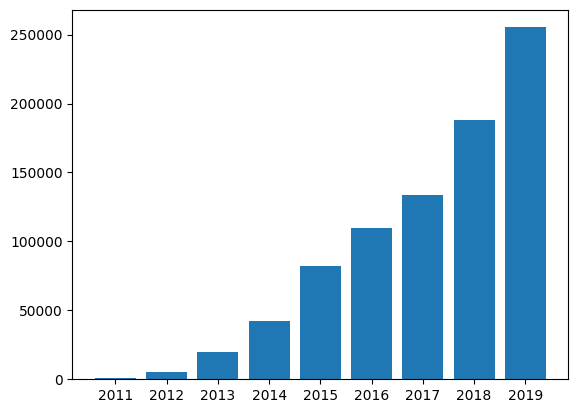

In [14]:
plotDictBar(num_docs,0)

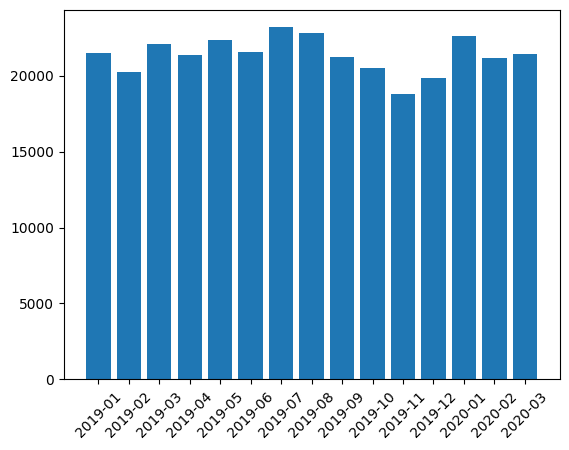

In [15]:
plotDictBar(monthly_num_docs,45)

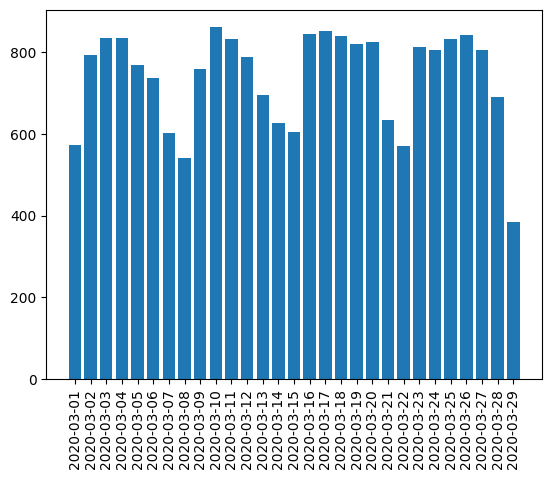

In [16]:
plotDictBar(daily_num_docs,90)

## Prediction (Skip this if hard and soft labels available)

In [17]:
import time
from collections import Counter

start_time = time.time()

from tqdm.notebook import tqdm
import multiprocessing
from joblib import Parallel, delayed

'''
def mytransform(cls):
    X_tfidf = tfidf_dict[cls].transform(X)
    return X_tfidf

def generateLabels(cls, X_tfidf):
    hard_v = model_dict[cls].predict(X_tfidf)
    soft_v = model_dict[cls].predict_proba(X_tfidf)[:,1]
    print(len(hard_v))
    print(hard_v)
    print(soft_v)
    return (hard_v, soft_v)

#class_list = ["TR-00-00-00-00"]
X = []
for doc in docs:
    text = ""
    if 'title' in doc.keys():
        text += doc['title']
    if 'selftext' in doc.keys():
        text += doc['selftext']
    X.append(text)

print("Created input test list.")

for cls in tqdm(class_list):
    X_tfidf = mytransform(cls)
    hard_v, soft_v = generateLabels(cls, X_tfidf)
    writeListFile("prevs/" + cls[:5], (hard_v, soft_v))
                                                
print("--- %s seconds ---" % (time.time() - start_time))
'''

'\ndef mytransform(cls):\n    X_tfidf = tfidf_dict[cls].transform(X)\n    return X_tfidf\n\ndef generateLabels(cls, X_tfidf):\n    hard_v = model_dict[cls].predict(X_tfidf)\n    soft_v = model_dict[cls].predict_proba(X_tfidf)[:,1]\n    print(len(hard_v))\n    print(hard_v)\n    print(soft_v)\n    return (hard_v, soft_v)\n\n#class_list = ["TR-00-00-00-00"]\nX = []\nfor doc in docs:\n    text = ""\n    if \'title\' in doc.keys():\n        text += doc[\'title\']\n    if \'selftext\' in doc.keys():\n        text += doc[\'selftext\']\n    X.append(text)\n\nprint("Created input test list.")\n\nfor cls in tqdm(class_list):\n    X_tfidf = mytransform(cls)\n    hard_v, soft_v = generateLabels(cls, X_tfidf)\n    writeListFile("prevs/" + cls[:5], (hard_v, soft_v))\n                                                \nprint("--- %s seconds ---" % (time.time() - start_time))\n'

## Load hard and soft labels

In [18]:
from collections import defaultdict
from tqdm.notebook import tqdm



def CC(hard_v):
    num_pos = Counter()
    cc = defaultdict() # year-prevalence
    for i in range(len(docs)):
        if hard_v[i] == 1:
            num_pos[docs[i]["year"]] += 1
    for k in num_docs.keys():
        cc[k] = num_pos[k] / num_docs[k]
    return cc


def PCC(soft_v):
    sum_prob = defaultdict()
    pcc = defaultdict() # year-prevalence
    for i in range(len(docs)):
        yr = docs[i]["year"]
        if yr in sum_prob.keys():
            sum_prob[yr] += soft_v[i]
        else:
            sum_prob[yr] = soft_v[i]
    for k in num_docs.keys():
        pcc[k] = sum_prob[k] / num_docs[k]
    return pcc
    
    


hard_dict = defaultdict()
soft_dict = defaultdict()


for cls in tqdm(class_list):
    label_list = []
    loadListFile("prevs/" + cls[:5], label_list)
    hard_dict[cls] = label_list[0]
    soft_dict[cls] = label_list[1]
    
print(hard_dict)


defaultdict(None, {'BU-00-00-00-00': array([0., 0., 0., ..., 0., 0., 1.]), 'CO-00-00-00-00': array([1., 0., 0., ..., 0., 0., 0.]), 'CR-00-00-00-00': array([0., 0., 0., ..., 0., 1., 0.]), 'ED-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'ES-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'FA-00-00-00-00': array([0., 0., 0., ..., 1., 0., 0.]), 'HE-00-00-00-00': array([0., 0., 0., ..., 0., 1., 0.]), 'HO-00-00-00-00': array([0., 1., 0., ..., 0., 0., 0.]), 'HO-06-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'IM-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'MO-00-00-00-00': array([0., 0., 0., ..., 0., 0., 1.]), 'TO-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-01-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-05-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'WO-00-00-00-00': array([0., 0., 0., ..., 0., 1., 0.])})


## Calculate Label Prior from Training Data(Legal Hands)

In [19]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
verbose = False
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))

'''
def predict_train(dfset: defaultdict, cls: str):  
    
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values

    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 

        X_train_tfidf = tfidf_dict[cls].transform(X_train)
        X_test_tfidf = tfidf_dict[cls].transform(X_test)

        out = model_dict[cls].predict(X_test_tfidf)
#        prob = model.predict_proba(X_test_tfidf)[:,1]
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
        n_iter += 1
    return preds
'''

url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)
oldCols = list(df.columns)
newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)        
cols = oldCols[:2] + newCols
df = df[cols]
df.sum(axis=0, skipna=True)


dfset = defaultdict()
label_prior = defaultdict()
y_train = defaultdict()
numdoc = defaultdict()

for cls in tqdm(class_list):
    preprocessing(dfset, cls)
    #y_train[cls] = predict_train(dfset, cls)
    tinydf = dfset[cls]
    y_train[cls] = tinydf[cls].values
    label_prior[cls] = np.mean(y_train[cls])
    print(cls + ": " + str(np.round(label_prior[cls], 4)))
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


BU-00-00-00-00: 0.0585
CO-00-00-00-00: 0.0911
CR-00-00-00-00: 0.1799
ED-00-00-00-00: 0.0132
ES-00-00-00-00: 0.0401
FA-00-00-00-00: 0.1748
HE-00-00-00-00: 0.0642
HO-00-00-00-00: 0.258
HO-06-00-00-00: 0.0205
IM-00-00-00-00: 0.0183
MO-00-00-00-00: 0.2561
TO-00-00-00-00: 0.183
TR-00-00-00-00: 0.1296
TR-01-00-00-00: 0.012
TR-05-00-00-00: 0.0171
WO-00-00-00-00: 0.1944



## Freq-e(Annual)

In [20]:
import freq_e

def FREQ_E(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        yr = docs[i]["year"]
        if yr in bucket.keys():
            bucket[yr].append(soft_dict[i])
        else:
            bucket[yr] = [soft_dict[i]]
            
    for k in num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

## CC, PCC, and Freq-e

[4.50811975e-03 9.13597121e-03 3.77609568e-05 ... 7.67167846e-04
 7.40348898e-03 9.13597121e-03]
0.1296111665004985


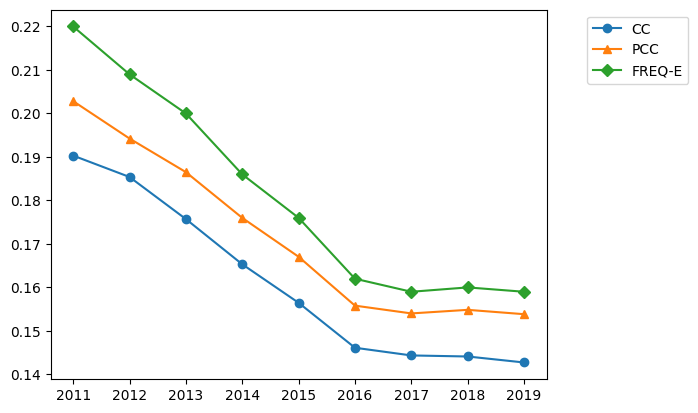

In [21]:
from collections import Counter
test_cls = "TR-00-00-00-00"
print(soft_dict[test_cls])
print(label_prior[test_cls])


cc = CC(hard_dict[test_cls])
pcc = PCC(soft_dict[test_cls])
freq_e_result = FREQ_E(soft_dict[test_cls], label_prior[test_cls])

plotDict(cc, 0, "-o")
plotDict(pcc, 0, "-^")
plotDict(freq_e_result, 0, "-D")

plt.legend(["CC", "PCC", "FREQ-E"], bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
#plt.legend(class_list,loc=1, prop={'size': 6})
plt.show()

## Annual Prevalence(2011/1/1 - 2019/12/31)

In [22]:
def plot_prev(class_list):
    m_list = ["-o", "-s", "-^"]
    i = 0
    for cls in tqdm(class_list[:7]):
        label_list = []
        loadListFile("prevs/" + cls[:5], label_list)
        hard_dict[cls] = label_list[0]
        soft_dict[cls] = label_list[1]
        #cc = CC(hard_dict[cls])
        result = FREQ_E(soft_dict[cls], label_prior[cls])
        marker = m_list[i//7]
        plotDict(result, 0, marker)
        i += 1
    plt.legend(class_list[:7], bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)
    plt.show()

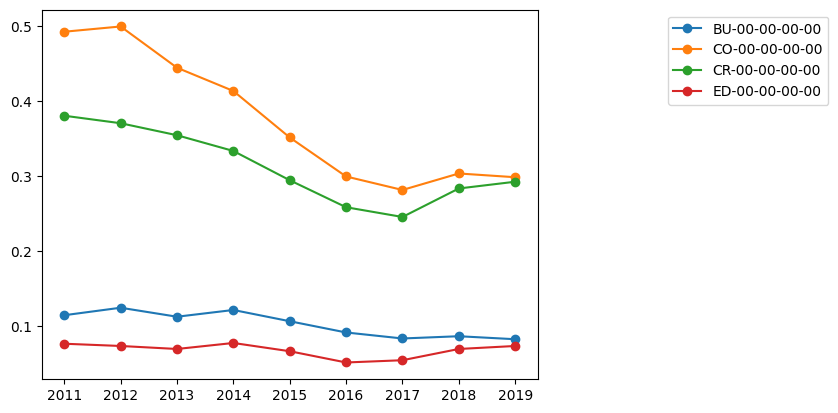

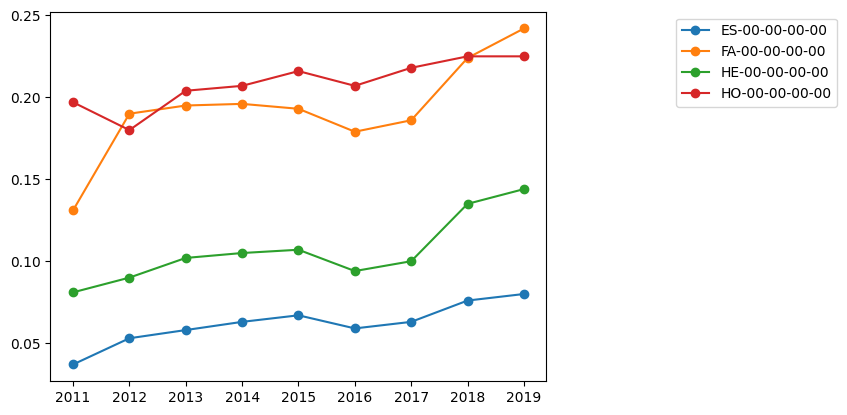

In [23]:
for i in tqdm([0,1]):
    plot_prev(class_list[4*i:4*i+4])

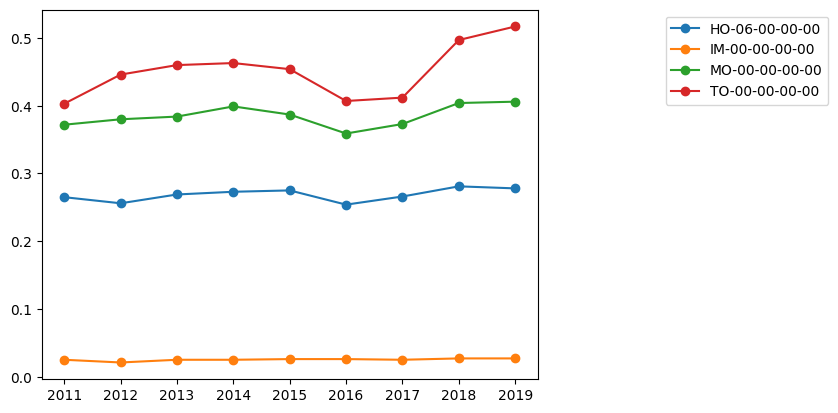

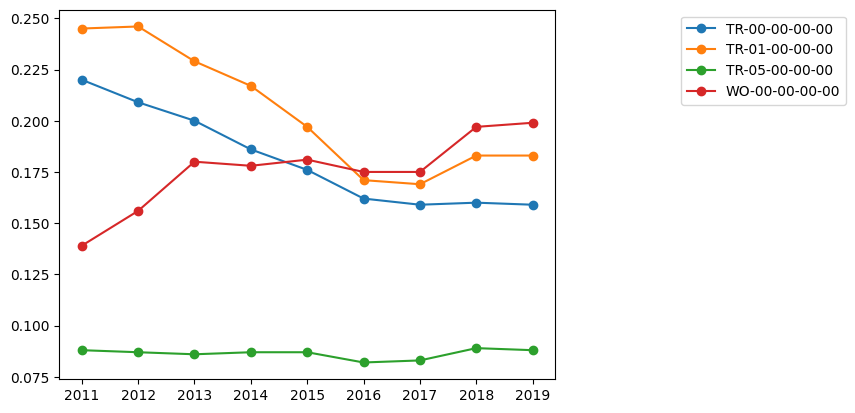

In [24]:
for i in tqdm([2,3]):
    plot_prev(class_list[4*i:4*i+4])

## Monthly Prevalence(2019/01/31-2020/03/29)

In [25]:
import freq_e

def FREQ_E_MONTHLY(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        mt = docs[i]["month"]
        if mt in bucket.keys():
            bucket[mt].append(soft_dict[i])
        else:
            bucket[mt] = [soft_dict[i]]
            
    # We collect keys only in monthly_num_docs
    for k in monthly_num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

In [26]:
def plot_prev_monthly(class_list):
    for cls in tqdm(class_list[:7]):
        label_list = []
        loadListFile("prevs/" + cls[:5], label_list)
        hard_dict[cls] = label_list[0]
        soft_dict[cls] = label_list[1]
        #cc = CC(hard_dict[cls])
        result = FREQ_E_MONTHLY(soft_dict[cls], label_prior[cls])

        plotDict(result, 45, "-s")
    plt.legend(class_list[:7], bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)
    plt.show()

HE-00: Health
HO-00: Housing
HO-06: Housing-Renting & Leasing
WO-00: Work and Employment Law


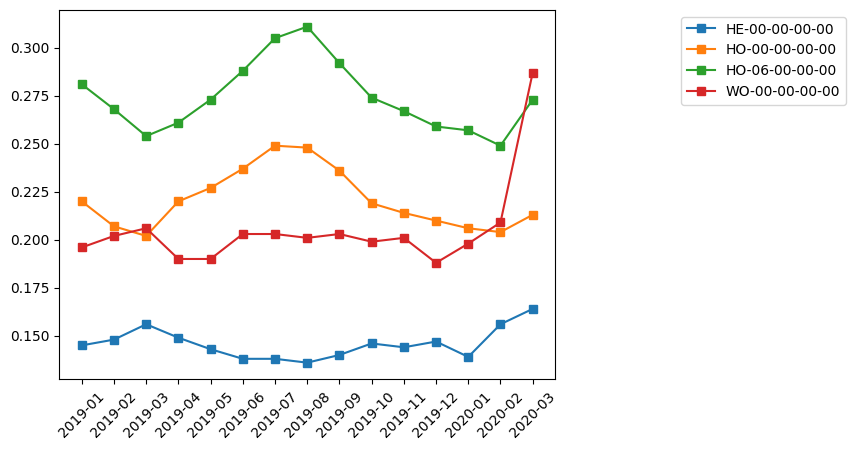

In [96]:
#for i in tqdm([0,1]):
#    plot_prev_monthly(class_list[4*i:4*i+4])
print("HE-00: Health")
print("HO-00: Housing")
print("HO-06: Housing-Renting & Leasing")
print("WO-00: Work and Employment Law")
plot_prev_monthly(["HE-00-00-00-00","HO-00-00-00-00","HO-06-00-00-00","WO-00-00-00-00"])



CO-00: Courts and Lawyers
CR-00: Crime and Prisons
FA-00: Family
TO-00: Accidents and Torts


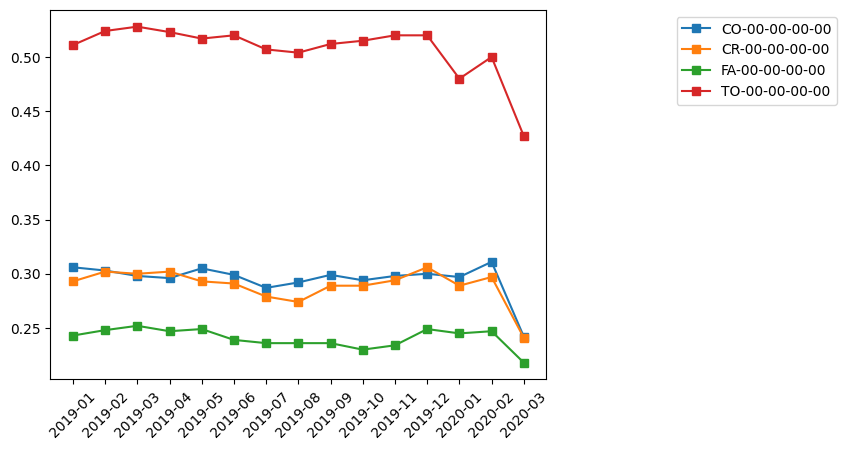

In [28]:
print("CO-00: Courts and Lawyers")
print("CR-00: Crime and Prisons")
print("FA-00: Family")
print("TO-00: Accidents and Torts")

plot_prev_monthly(["CO-00-00-00-00","CR-00-00-00-00","FA-00-00-00-00","TO-00-00-00-00"])

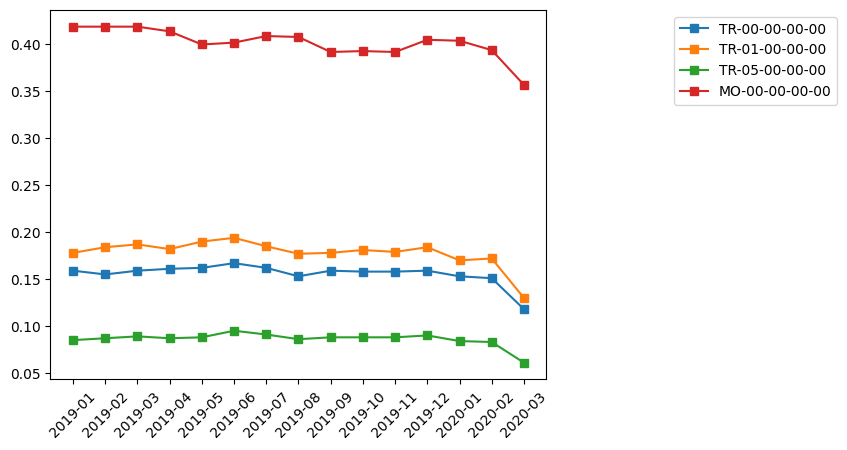

In [29]:
#for i in tqdm([2,3]):
#    plot_prev_monthly(class_list[4*i:4*i+4])
plot_prev_monthly(["TR-00-00-00-00","TR-01-00-00-00","TR-05-00-00-00","MO-00-00-00-00"])


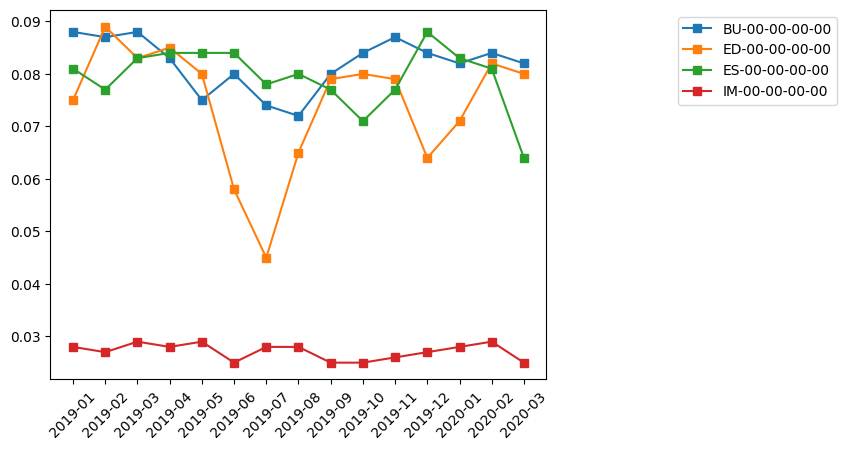

In [30]:
plot_prev_monthly(["BU-00-00-00-00","ED-00-00-00-00","ES-00-00-00-00","IM-00-00-00-00"])

## Daily Prevalence(2020/3/1 - 2020/3/29)

In [114]:
import freq_e

def FREQ_E_DAILY(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        day = docs[i]["day"]
        if day in bucket.keys():
            bucket[day].append(soft_dict[i])
        else:
            bucket[day] = [soft_dict[i]]
            
    # We collect keys only in monthly_num_docs
    for k in daily_num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

In [111]:
import datetime
import matplotlib.dates as mdates 


import matplotlib as mpl





def plot_prev_daily(class_list):
    for cls in tqdm(class_list[:7]):
        label_list = []
        loadListFile("prevs/" + cls[:5], label_list)
        hard_dict[cls] = label_list[0]
        soft_dict[cls] = label_list[1]
        #cc = CC(hard_dict[cls])
        result = FREQ_E_DAILY(soft_dict[cls], label_prior[cls])
        plotDict(result, 90, "-")
    plt.legend(class_list[:7], bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)

    

    



HE-00: Health
HO-00: Housing
HO-06: Housing-Renting & Leasing
WO-00: Work and Employment Law


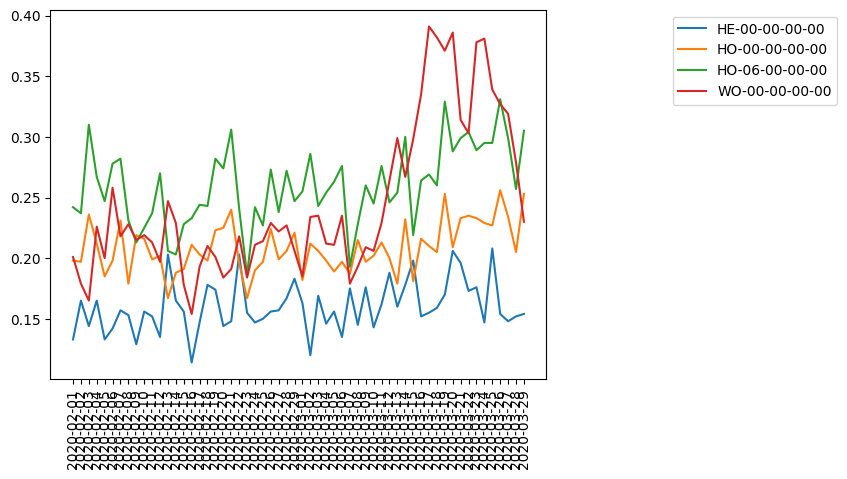

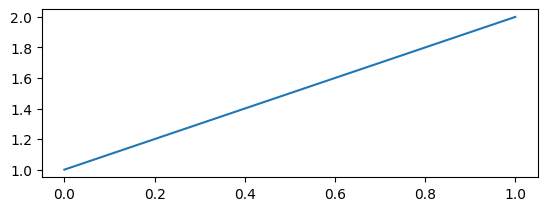

In [120]:
#for i in tqdm([0,1]):
#    plot_prev_monthly(class_list[4*i:4*i+4])
print("HE-00: Health")
print("HO-00: Housing")
print("HO-06: Housing-Renting & Leasing")
print("WO-00: Work and Employment Law")
plot_prev_daily(["HE-00-00-00-00","HO-00-00-00-00","HO-06-00-00-00","WO-00-00-00-00"])



CO-00: Courts and Lawyers
CR-00: Crime and Prisons
FA-00: Family
TO-00: Accidents and Torts


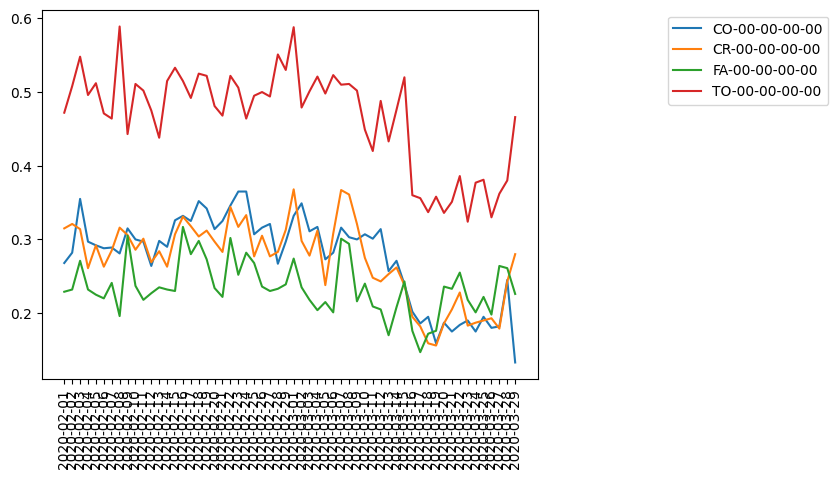

In [83]:
print("CO-00: Courts and Lawyers")
print("CR-00: Crime and Prisons")
print("FA-00: Family")
print("TO-00: Accidents and Torts")

plot_prev_daily(["CO-00-00-00-00","CR-00-00-00-00","FA-00-00-00-00","TO-00-00-00-00"])

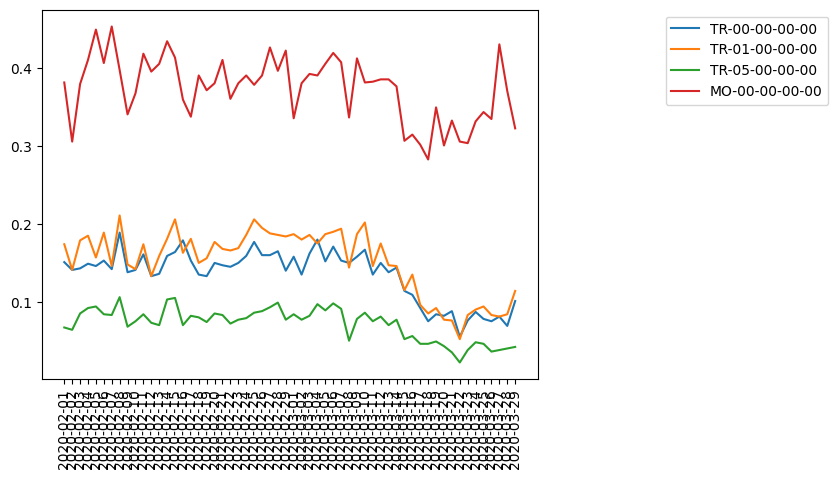

In [84]:
#for i in tqdm([2,3]):
#    plot_prev_monthly(class_list[4*i:4*i+4])
plot_prev_daily(["TR-00-00-00-00","TR-01-00-00-00","TR-05-00-00-00","MO-00-00-00-00"])


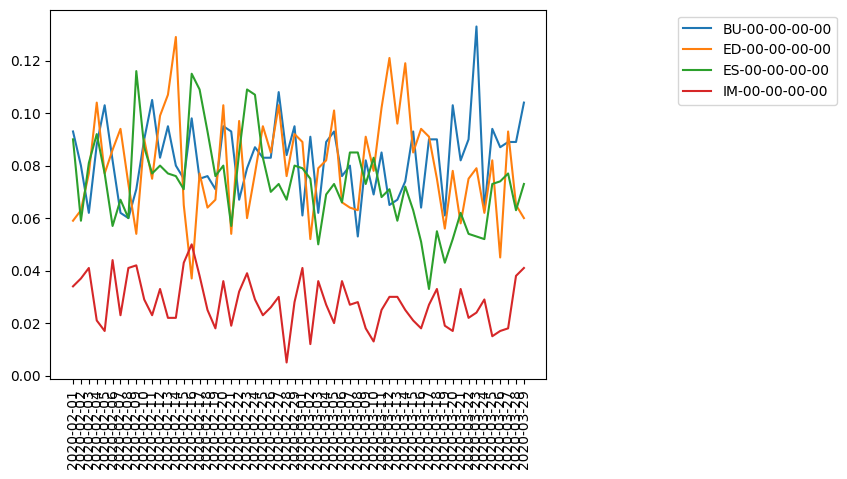

In [85]:
plot_prev_daily(["BU-00-00-00-00","ED-00-00-00-00","ES-00-00-00-00","IM-00-00-00-00"])